# Importing Libraries

In [1]:
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2
#from basic_imports import *
#import pandas

#from math import radians, cos, sin, asin, sqrt

# import folium
# import datetime
# from constants import *
# from load_files import *
# from scipy.stats import *
# from scipy import spatial
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#import statsmodels.api as sm
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, Reshape, GRU, Bidirectional
# from tensorflow.keras.layers import MaxPool2D, MaxPooling2D, MaxPooling1D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow import keras

In [2]:
plt.style.use('default')

In [3]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Loading files

In [3]:
mexico = pd.read_csv("../preprocessing/peeps_test.csv")

In [7]:
#mexico = mexico.drop("Unnamed: 0", axis=1)

In [4]:
mexico = mexico[~mexico.duplicated()]

In [170]:
mexico = mexico.set_index('timestamp')

In [171]:
mexico = mexico.drop(['temperature', 'UUID'], axis=1)

In [172]:
mexico = mexico.dropna()

In [173]:
mexico.describe()

pm2_5      humidity  gpsLongitude   gpsLatitude
count  55578.000000  55578.000000  55578.000000  55578.000000
mean     170.924178     47.880442     60.073389     22.251600
std      211.280264     20.564825     32.059685     11.875278
min        1.809467      0.000000      0.000000      0.000000
25%       37.382153     33.700000     77.056328     28.424345
50%       91.753265     48.900000     77.159676     28.580520
75%      217.022659     62.900000     77.207756     28.631804
max     1838.637207     93.200000     77.408485     28.698816

# Preprocessing

In [174]:
split_percent = 0.70
split = int(split_percent*len(mexico))

In [175]:
dataset = mexico.values

In [176]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [187]:
past_history = (9)
future_target = 6
STEP=1


X_train, y_train = multivariate_data(dataset, dataset[:, 0], 0,
                                                   split, past_history,
                                                   future_target, STEP)
X_test, y_test = multivariate_data(dataset, dataset[:, 0],
                                               split, None, past_history,
                                               future_target, STEP)

In [178]:
print(X_train.shape)
print(y_train.shape)
print ('Single window of past history : {}'.format(X_train[0].shape))
print(X_train.shape[-2:])
print(y_train[0].shape)

(33202, 12, 4)
(33202, 6)
Single window of past history : (12, 4)
(12, 4)
(6,)


In [179]:
print ('Single window of past history. Shape: {}'.format(X_train[0].shape))
print (X_train[1])
print ('\n Target pm2.5 to predict. Shape: {}'.format(y_train[0].shape))
print (y_train[1])

Single window of past history. Shape: (12, 4)
[[ 74.9661026   50.6          0.           0.        ]
 [ 65.55486298  33.4         77.24456024  28.58052444]
 [ 37.32824326  30.7         77.24460602  28.58052254]
 [ 45.41475296  41.1         77.24467468  28.58060646]
 [ 46.72301102  49.8         77.24449921  28.58050919]
 [ 59.79771805  57.          77.24458313  28.58052254]
 [ 75.2209549   60.2         77.24467468  28.5804882 ]
 [ 87.31044769  60.3         77.24475861  28.58051682]
 [117.33078766  63.8         77.24445343  28.58045578]
 [160.47181702  66.          77.2447052   28.58047867]
 [227.07963562  67.7         77.24490356  28.58048248]
 [221.80455017  67.1         77.24459839  28.58051491]]

 Target pm2.5 to predict. Shape: (6,)
[237.39833069 256.72360229 232.26319885 223.23152161 210.63482666
 214.30517578]


# Training RNNs

## TWO LAYER LSTM

In [99]:
multi_step_model = Sequential()
multi_step_model.add(LSTM(200,return_sequences=True,input_shape=X_train.shape[-2:]))
multi_step_model.add(LSTM(100, activation='relu'))
multi_step_model.add(Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer='adam', loss='mae')
#print(multi_step_model.summary())
multi_step_model.fit(X_train, y_train, epochs=20, batch_size=128)

Train on 33058 samples
Epoch 1/20
33058/33058 [==============================] - 71s 2ms/sample - loss: 174.4057
Epoch 2/20
33058/33058 [==============================] - 70s 2ms/sample - loss: 124.9414
Epoch 3/20
21120/33058 [==================>...........] - ETA: 25s - loss: 110.9963

KeyboardInterrupt: 

In [64]:
m_pred = multi_step_model.predict(X_test)

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, m_pred))
mae = mean_absolute_error(y_test, m_pred)
mape = mean_absolute_percentage_error(y_test, m_pred)

print(rmse, mae, mape)

37.895982442947314 17.529562460654034 48.01871898990396


## GRU

In [ ]:
gru_model = Sequential()
gru_model.add(GRU (units = 100, activation='relu', input_shape = X_train.shape[-2:]))
gru_model.add(Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
gru_model.add(Dense(6))
gru_model.compile(optimizer='adam',loss='mae')

gru_model.fit(X_train, y_train, epochs=10, batch_size=32)

## One Layer LSTM

In [57]:
# model = Sequential()
# # Input layer
# model.add(GRU (units = 64, return_sequences = True, 
# input_shape = X_train.shape[-2:]))
# model.add(Dropout(0.2)) 
# # Hidden layer
# model.add(GRU(units = 64)) 
# model.add(Dropout(0.2))
# model.add(Dense(units = 6)) 
# #Compile model
# model.compile(optimizer='adam',loss='mae')

model = Sequential()
# Input layer
model.add(GRU (units = 100, input_shape = X_train.shape[-2:]))
# Hidden layer
#model.add(Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dense(units = 6)) 
#Compile model
model.compile(optimizer='adam',loss='mae')

model.fit(X_train, y_train, epochs=3, batch_size=128)

In [ ]:
model = Sequential()
model.add(LSTM(units = 100, activation='relu', input_shape=X_train.shape[-2:]))

#model.add(Dropout(0.1))

model.add(Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))

model.add(Dense(24))
optimizer = tf.keras.optimizers.Adam(0.00001)
#optimizer=tf.keras.optimizers.RMSprop()

model.compile(optimizer='adam', loss = 'mean_absolute_percentage_error', batch_size=64)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, epochs=5, batch_size=128)#,validation_split = (12.5/87.5), callbacks=[callback])

Train on 33202 samples
Epoch 1/5
20736/33202 [=================>............] - ETA: 5s - loss: 64.3552

In [189]:
y_pred = model.predict(X_test)

In [193]:
cy_test = y_test[:,5]

In [194]:
cy_pred = y_pred[:,5]

In [195]:
rmse = np.sqrt(mean_squared_error(cy_test, cy_pred))
mae = mean_absolute_error(cy_test, cy_pred)
mape = mean_absolute_percentage_error(cy_test, cy_pred)

print(rmse, mae, mape) #12prev

57.384882297636004 26.940068218195197 72.85112087210474


### Plotting LSTM Results

<AxesSubplot:>

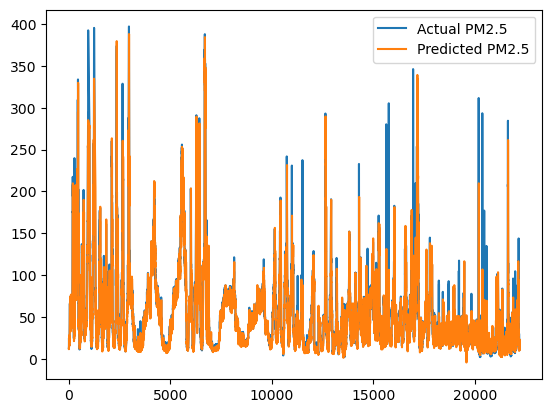

In [383]:
yt.plot()

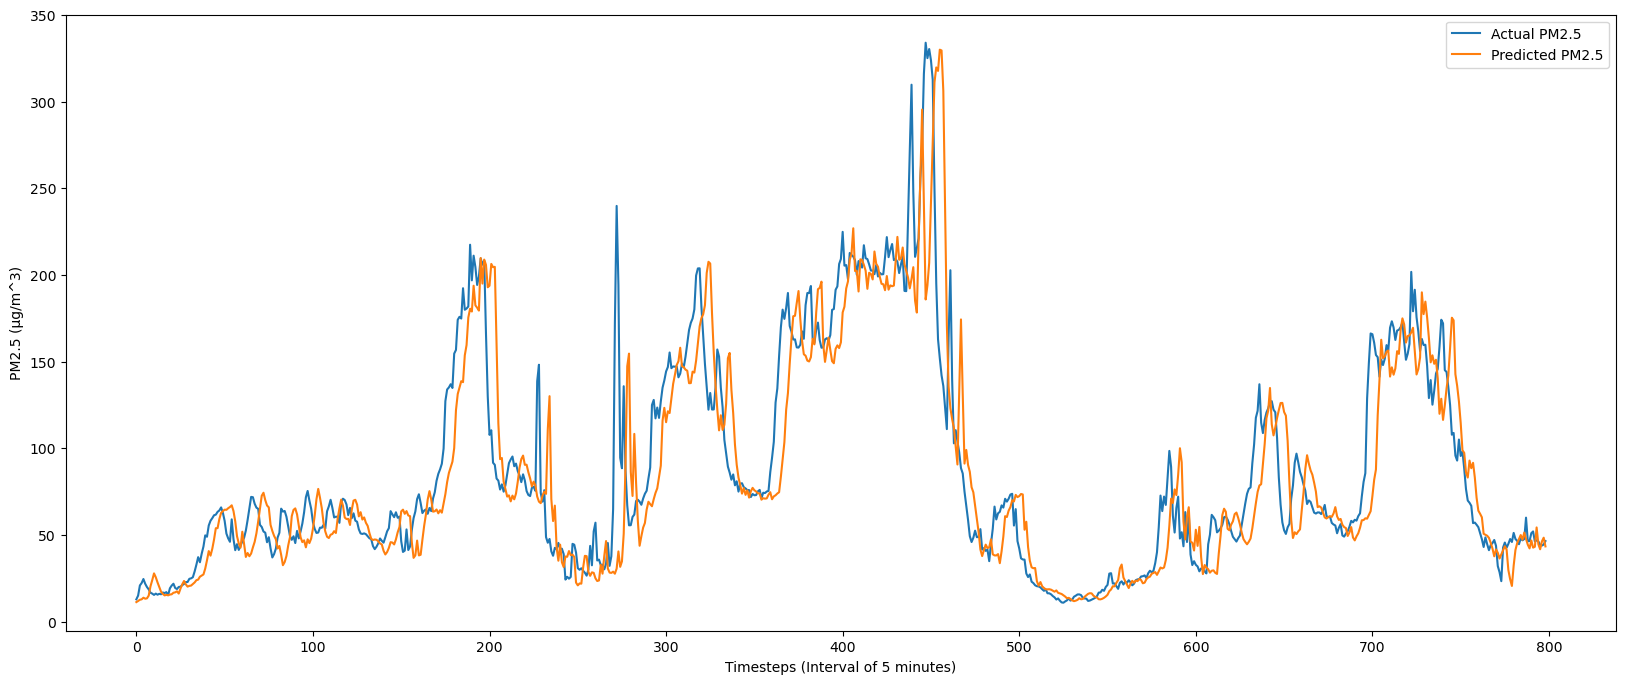

In [389]:
plt.figure(figsize=(20,8))
plt.plot(cy_test[1:800], label = 'Actual PM2.5')
plt.ylabel('PM2.5 (µg/m^3)')
plt.xlabel('Timesteps (Interval of 5 minutes)')
plt.plot(cy_pred[1:800], label = 'Predicted PM2.5')
plt.legend()
plt.show()

In [66]:
def create_time_steps(length):
    return list(range(-length, 0))

In [67]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.figure(figsize=(14,5))
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')

    return plt

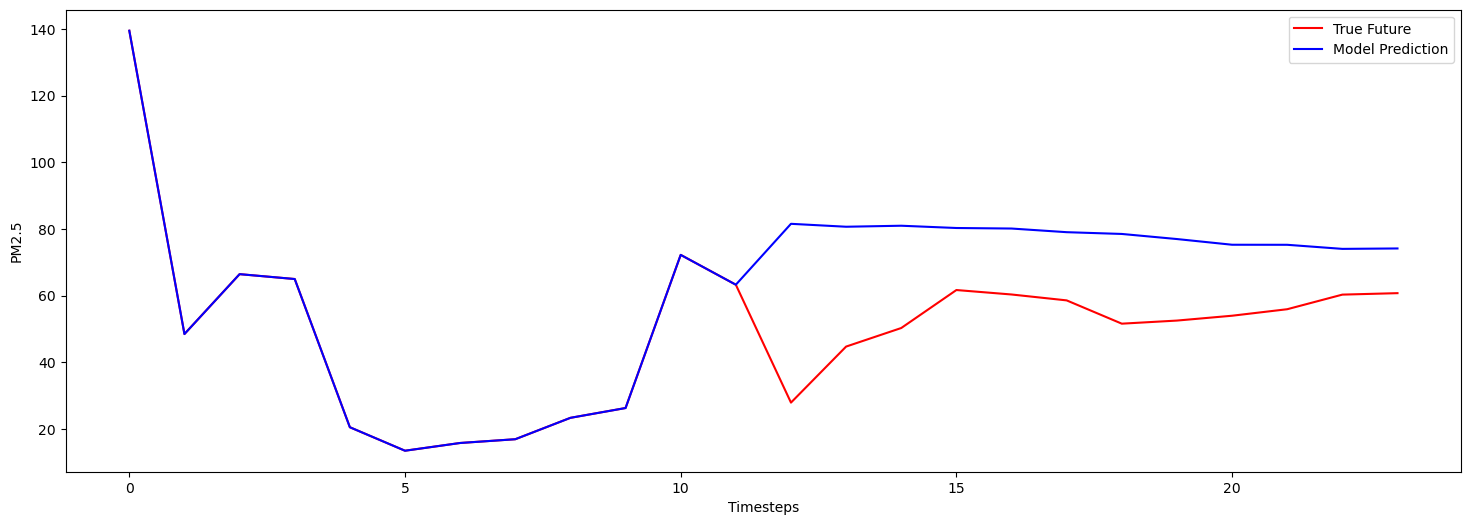

In [29]:
labels = ['True Future', 'Model Prediction']


plt.figure(figsize=(18,6))
plt.plot(np.append(X_test[:, :, 0][480],  y_test[480]), 'red', label=labels[0])
plt.plot(np.append(X_test[:, :, 0][480],  y_pred[480]), 'blue', label=labels[1])
plt.legend()
plt.ylabel('PM2.5')
plt.xlabel('Timesteps')
plt.show()

In [421]:
def create_time_steps(length):
    return list(range(-length, 0))

In [422]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.figure(figsize=(14,5))
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')

    return plt

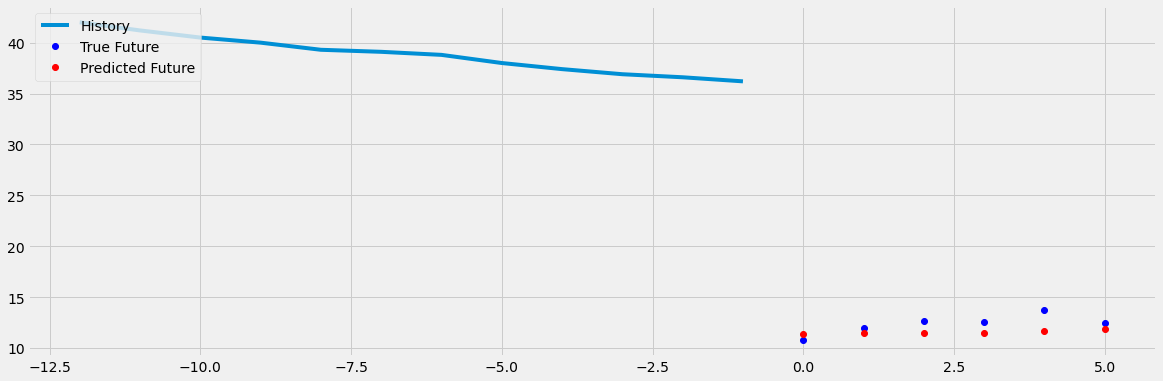

In [338]:
multi_step_plot(X_test[0], y_test[0], y_pred[0])

### Making Prediction dataset for Spatiotemporal Approach-A

In [ ]:
#half hour intervals

In [278]:
pred_df = mexico.tail(39251)[0:-1]

In [279]:
pred_df['preds'] = cy_pred

In [280]:
pred_df

pm2_5  hour_of_day  day_of_week  humidity  \
timestamp                                                                  
2020-01-04 00:09:44-06:00  10.559058            0            5      50.9   
2020-01-04 00:13:44-06:00   9.186334            0            5      51.1   
2020-01-04 00:17:44-06:00   8.372658            0            5      50.9   
2020-01-04 00:21:44-06:00   7.456677            0            5      51.1   
2020-01-04 00:25:44-06:00   9.134992            0            5      51.6   
...                              ...          ...          ...       ...   
2020-02-17 05:31:21-06:00   0.894799            5            0      28.7   
2020-02-17 05:35:20-06:00   0.894799            5            0      28.6   
2020-02-17 05:39:21-06:00   0.894799            5            0      28.1   
2020-02-17 05:43:21-06:00   0.894799            5            0      28.0   
2020-02-17 05:47:21-06:00   0.894799            5            0      26.8   

                           gpsLongitude  gpsLatitude              UUID  \
timestamp                                                                
2020-01-04 00:09:44-06:00   -103.333260    20.673824  3AB8A58A952B89B6   
2020-01-04 00:13:44-06:00   -103.333260    20.673824  3AB8A58A952B89B6   
2020-01-04 00:17:44-06:00   -103.333260    20.673824  3AB8A58A952B89B6   
2020-01-04 00:21:44-06:00   -103.333260    20.673824  3AB8A58A952B89B6   
2020-01-04 00:25:44-06:00   -103.333260    20.673824  3AB8A58A952B89B6   
...                                 ...          ...               ...   
2020-02-17 05:31:21-06:00   -103.359337    20.674721  DA1F257AD20C85A7   
2020-02-17 05:35:20-06:00   -103.359337    20.674721  DA1F257AD20C85A7   
2020-02-17 05:39:21-06:00   -103.359337    20.674721  DA1F257AD20C85A7   
2020-02-17 05:43:21-06:00   -103.359337    20.674721  DA1F257AD20C85A7   
2020-02-17 05:47:21-06:00   -103.359337    20.674721  DA1F257AD20C85A7   

                              preds  
timestamp                            
2020-01-04 00:09:44-06:00  4.984613  
2020-01-04 00:13:44-06:00  4.933288  
2020-01-04 00:17:44-06:00  5.227934  
2020-01-04 00:21:44-06:00  5.487255  
2020-01-04 00:25:44-06:00  6.626673  
...                             ...  
2020-02-17 05:31:21-06:00  6.354121  
2020-02-17 05:35:20-06:00  4.043547  
2020-02-17 05:39:21-06:00  2.652471  
2020-02-17 05:43:21-06:00  1.719637  
2020-02-17 05:47:21-06:00  1.576077  

[39250 rows x 8 columns]

In [281]:
pred_df.to_csv("stat_pred.csv")

In [389]:
#---------

In [83]:
pred_df

pm2_5  humidity  gpsLongitude  gpsLatitude  \
timestamp                                                                   
2019-03-12 14:24:33+05:30  11.037766      38.8     77.071045    28.644163   
2019-03-12 14:29:33+05:30  10.844752      38.0     77.071045    28.644163   
2019-03-12 14:34:33+05:30  11.326016      37.4     77.070953    28.644104   
2019-03-12 14:39:33+05:30  11.678432      36.9     77.070953    28.644104   
2019-03-12 14:44:33+05:30  11.684157      36.6     77.070953    28.644104   
...                              ...       ...           ...          ...   
2019-04-18 12:18:01+05:30  16.014563      33.5     77.207176    28.632109   
2019-04-18 12:23:02+05:30  14.053155      33.6     77.207176    28.632109   
2019-04-18 12:28:02+05:30  12.760948      33.2     77.207176    28.632109   
2019-04-18 12:33:01+05:30  13.163043      32.8     77.207176    28.632109   
2019-04-18 12:38:01+05:30  14.707955      33.1     77.207176    28.632109   

                               preds  
timestamp                             
2019-03-12 14:24:33+05:30  13.875405  
2019-03-12 14:29:33+05:30  12.508500  
2019-03-12 14:34:33+05:30  11.743327  
2019-03-12 14:39:33+05:30  11.741287  
2019-03-12 14:44:33+05:30  12.149193  
...                              ...  
2019-04-18 12:18:01+05:30  12.856312  
2019-04-18 12:23:02+05:30  12.748899  
2019-04-18 12:28:02+05:30  12.568728  
2019-04-18 12:33:01+05:30  12.495444  
2019-04-18 12:38:01+05:30  12.485712  

[22225 rows x 5 columns]

# Naive forecasting

In [274]:
X_test[0]

array([[15.26855564, 42.        , 77.07104492, 28.64416313],
       [13.95030975, 41.2       , 77.07104492, 28.64416313],
       [14.12250423, 40.5       , 77.07104492, 28.64416313],
       [13.97071457, 40.        , 77.07104492, 28.64416313],
       [12.55820751, 39.3       , 77.07104492, 28.64416313],
       [13.67961025, 39.1       , 77.07104492, 28.64416313],
       [11.0377655 , 38.8       , 77.07104492, 28.64416313],
       [10.84475231, 38.        , 77.07104492, 28.64416313],
       [11.32601643, 37.4       , 77.07095337, 28.644104  ],
       [11.67843246, 36.9       , 77.07095337, 28.644104  ],
       [11.68415737, 36.6       , 77.07095337, 28.644104  ],
       [11.60278416, 36.2       , 77.07095337, 28.644104  ]])

In [281]:
n_pred = X_test[:, :, 0]

In [284]:
rmse = np.sqrt(mean_squared_error(y_test, n_pred))
mae = mean_absolute_error(y_test, n_pred)
mape = mean_absolute_percentage_error(y_test, n_pred)

print(rmse, mae, mape)

41.20632205956808 14.947803678776529 28.946229381963374


In [285]:
cy_test = y_test[:,11]

In [286]:
cy_pred = n_pred[:,11]

In [287]:
rmse = np.sqrt(mean_squared_error(cy_test, cy_pred))
mae = mean_absolute_error(cy_test, cy_pred)
mape = mean_absolute_percentage_error(cy_test, cy_pred)

print(rmse, mae, mape) #12prev

41.20618392440375 14.947028800104382 28.944592951648062


In [57]:
cy_test

array([11.60278416, 10.76193523, 12.01040936, ..., 12.76094818,
       13.16304302, 14.70795536])

In [58]:
cy_pred

array([13.67961025, 11.0377655 , 10.84475231, ..., 10.74074841,
       10.85237026, 13.47286606])

### Training Naïve

In [16]:
def naive_results(combinations, window_size, future_target):
    results = {}
    for i in range(len(combinations)):
        size = len(combinations[i])
        mean = combinations[i]['pm2_5'].mean()
        df = combinations[i]
        X_train, y_train, X_test, y_test = ms_temporal_set(df, window_size, future_target)
        
        
        y_pred = X_test[:, :, 0]
        
        

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results[i] = (size, mean, rmse, mae, mape)
        
    return results

In [24]:
print(tabulate([(k,) + v for k,v in results.items()], headers = ["combination","size","mean","rmse", "mae", "mape"])) 

  combination    size     mean     rmse      mae     mape
-------------  ------  -------  -------  -------  -------
            0   55578  170.924  23.6376  7.38812  14.7708
